In [1]:
%matplotlib inline
import pandas as pd
import datetime
import pandas_datareader.data as web
import matplotlib.pyplot as plt
import torch
from torch.utils.data import Dataset, DataLoader, SubsetRandomSampler
from torch.utils.data.dataloader import default_collate
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
from IPython.display import clear_output
from torch.autograd import Variable
from mpl_toolkits.mplot3d import Axes3D
print(torch.__version__)

1.1.0


In [2]:
reqd_len = 150
channels = 3
class IMUDataset(Dataset):
    def __init__(self, transform = None):
        self.df = pd.read_csv('../data/train.csv', header = None)
        self.transform = transform
        print(self.df.shape)
        
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, idx):
        x = self.df.iloc[idx : idx + reqd_len, : channels].values
        x = x.astype('float')
        x = x.reshape(reqd_len, channels)
        assert(x.shape == (reqd_len, channels))
        return x
        
dataset = IMUDataset()

(120150, 8)


In [3]:
batch_size = 8
train_indices = [(i * reqd_len) for i in range(len(dataset) // reqd_len)]

trainloader = DataLoader(dataset, batch_size = batch_size, sampler = SubsetRandomSampler(train_indices), drop_last = True)

In [4]:
signal = next(iter(trainloader))
print(signal.shape)

torch.Size([8, 150, 3])


In [5]:
# for xavier initialization of network
def init_weights(m):
    if type(m) == nn.Linear:
        torch.nn.init.xavier_uniform_(m.weight)
        m.bias.data.fill_(0.01)
        
class AutoEncoder(nn.Module) :
    def __init__(self) : 
        super(AutoEncoder, self).__init__()
        # defining layers
        self.encoder = nn.Sequential(
            nn.Linear(3 * 150, 256),
            nn.ReLU(),
            nn.Linear(256, 128),
            nn.ReLU()
        )
        self.decoder = nn.Sequential(
            nn.Linear(128, 256),
            nn.ReLU(),
            nn.Linear(256, 3 * 150),
            nn.Sigmoid()
        )
        self.classifier = nn.Sequential(
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 5),
            nn.Softmax(dim = 1)
        )
        
    def forward(self, x, encode = False, classify = False) :
        x = x.view(-1, 3 * 150)
        features = self.encoder(x)
        
        if encode and not classify:
            return features
        elif not encode and classify :
            return self.classifier(features)
        else : 
            return self.decoder(features)

In [6]:
Net = AutoEncoder()
Net.apply(init_weights)
if torch.cuda.is_available() : 
    Net = Net.cuda()
    print('Model on GPU')

In [7]:
import torch.optim as optim
criterion = nn.MSELoss()
optimizer = optim.Adam(Net.parameters(), lr = 1e-4)

In [8]:
num_epochs = 30
total_step = len(dataset) // (batch_size * 150)
train_loss_list = list()
min_loss = 100
for epoch in range(num_epochs):
    trn = []
    Net.train()
    for i, signals in enumerate(trainloader) :
        if torch.cuda.is_available():
            signals = Variable(signals).cuda().float()
        else : 
            signals = Variable(signals).float()
        
        reconstr = Net.forward(signals)
        flattened_sig = signals.view(-1, 3 * 150).float()
        loss = criterion(reconstr, flattened_sig)
        trn.append(loss.item())

        optimizer.zero_grad()
        loss.backward()
#         torch.nn.utils.clip_grad_value_(Net.parameters(), 10)
        optimizer.step()

        if i % 20 == 0 :
            print('epoch = ', epoch, ' step = ', i, ' of total steps ', total_step, ' loss = ', loss.item())
            
    train_loss = (sum(trn) / len(trn))
    train_loss_list.append(train_loss)
    
    if train_loss < min_loss : 
        min_loss = train_loss
        torch.save(Net.state_dict() , '../saved_models/autoencoder2.pt')
        print('Saving model', min_loss)

epoch =  0  step =  0  of total steps  100  loss =  0.269487202167511
epoch =  0  step =  20  of total steps  100  loss =  0.2515990436077118
epoch =  0  step =  40  of total steps  100  loss =  0.2366720288991928
epoch =  0  step =  60  of total steps  100  loss =  0.21145915985107422
epoch =  0  step =  80  of total steps  100  loss =  0.14066709578037262
Saving model 0.2098774480074644
epoch =  1  step =  0  of total steps  100  loss =  0.11119041591882706
epoch =  1  step =  20  of total steps  100  loss =  0.042466048151254654
epoch =  1  step =  40  of total steps  100  loss =  0.025498243048787117
epoch =  1  step =  60  of total steps  100  loss =  0.03751590847969055
epoch =  1  step =  80  of total steps  100  loss =  0.029690926894545555
Saving model 0.034440249819308516
epoch =  2  step =  0  of total steps  100  loss =  0.02085738815367222
epoch =  2  step =  20  of total steps  100  loss =  0.016903266310691833
epoch =  2  step =  40  of total steps  100  loss =  0.022025

epoch =  20  step =  60  of total steps  100  loss =  0.020240120589733124
epoch =  20  step =  80  of total steps  100  loss =  0.023248257115483284
Saving model 0.01930502318777144
epoch =  21  step =  0  of total steps  100  loss =  0.021167388185858727
epoch =  21  step =  20  of total steps  100  loss =  0.02179107442498207
epoch =  21  step =  40  of total steps  100  loss =  0.022653944790363312
epoch =  21  step =  60  of total steps  100  loss =  0.023650435730814934
epoch =  21  step =  80  of total steps  100  loss =  0.019053205847740173
Saving model 0.019275116696953774
epoch =  22  step =  0  of total steps  100  loss =  0.023060528561472893
epoch =  22  step =  20  of total steps  100  loss =  0.013726058416068554
epoch =  22  step =  40  of total steps  100  loss =  0.026613766327500343
epoch =  22  step =  60  of total steps  100  loss =  0.01477554440498352
epoch =  22  step =  80  of total steps  100  loss =  0.01432587020099163
Saving model 0.019221143601462244
epoc

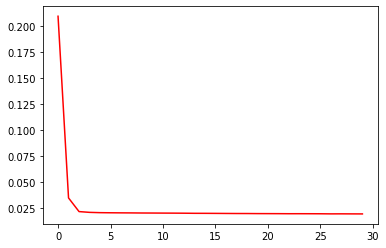

In [9]:
j = range(30)
plt.plot(j, train_loss_list, 'r')

### Verifying that AutoEncoder has not learnt the identity function

In [10]:
print(Net.encoder[0].weight)
print(Net.encoder[2].weight)
print(Net.decoder[0].weight)
print(Net.decoder[2].weight)

Parameter containing:
tensor([[-0.0866, -0.0942, -0.0073,  ..., -0.0961, -0.0466, -0.0481],
        [-0.0101,  0.0382,  0.0039,  ...,  0.0759, -0.0796, -0.0920],
        [ 0.0330, -0.0116,  0.0621,  ..., -0.0659,  0.0039,  0.0442],
        ...,
        [-0.0173,  0.0754,  0.0160,  ..., -0.0377,  0.0085,  0.0560],
        [ 0.0997, -0.0156,  0.0770,  ...,  0.0851,  0.0139, -0.0339],
        [-0.0080,  0.0655,  0.0362,  ...,  0.0281,  0.0483,  0.0284]],
       requires_grad=True)
Parameter containing:
tensor([[-0.0578,  0.0384, -0.0164,  ..., -0.0446, -0.0532,  0.0761],
        [-0.0465,  0.1279, -0.0305,  ...,  0.1016,  0.0368, -0.0750],
        [-0.0874,  0.0632, -0.0779,  ...,  0.1208,  0.0016,  0.1435],
        ...,
        [ 0.0329,  0.0132,  0.1031,  ...,  0.0361, -0.1046, -0.0717],
        [ 0.0978,  0.0325,  0.1080,  ...,  0.0849, -0.0124,  0.1330],
        [-0.0875,  0.0164, -0.0488,  ..., -0.0495,  0.1138,  0.0683]],
       requires_grad=True)
Parameter containing:
tensor([[ 0.

### Now training the classifier

In [11]:
reqd_len = 150
channels = 3
class IMUDataset(Dataset):
    def __init__(self, mode = 'test', transform = None):
        if mode == 'train' :
            self.df = pd.read_csv('../data/train.csv', header = None)
        elif mode == 'test' :
            self.df = pd.read_csv('../data/test.csv', header = None)
        elif mode == 'val' :
            self.df = pd.read_csv('../data/val.csv', header = None)
        self.transform = transform
        print(self.df.shape)
        
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, idx):
        y = self.df.iloc[idx : idx + reqd_len, 3 : ].values
        ind = np.argmax(np.sum(y, axis = 0))
        label = np.zeros_like(self.df.iloc[0, 3 : ].values)
        label = label.astype('float')
        label[ind] = 1
        x = self.df.iloc[idx : idx + reqd_len, : channels].values
        x = x.astype('float')
        x = x.reshape(reqd_len, channels)
        assert(x.shape == (reqd_len, channels))
        assert(label.shape == (5, ))
        return x, label
        
trainset = IMUDataset(mode = 'train')
valset = IMUDataset(mode = 'val')
testset = IMUDataset(mode = 'test')

(120150, 8)
(19950, 8)
(20100, 8)


In [12]:
train_batch_size = 8
batch_size = 8
train_indices = [(i * reqd_len) for i in range(len(trainset) // reqd_len)]
val_indices = [(i * reqd_len) for i in range(len(valset) // reqd_len)]
test_indices = [(i * reqd_len) for i in range(len(testset) // reqd_len)]

trainloader = DataLoader(trainset, batch_size = train_batch_size, sampler = SubsetRandomSampler(train_indices), drop_last = True)
valloader = DataLoader(valset, batch_size = batch_size, sampler = SubsetRandomSampler(val_indices), drop_last = True)
testloader = DataLoader(testset, batch_size = batch_size, sampler = SubsetRandomSampler(test_indices), drop_last = True)

In [13]:
# Loading autoencoder saved model
Net = AutoEncoder()
Net.load_state_dict(torch.load('../saved_models/autoencoder2.pt'), strict = False)
# freezing encoder and decoder layers
Net.encoder[0].requires_grad = False
Net.encoder[2].requires_grad = False
Net.decoder[0].requires_grad = False
Net.decoder[2].requires_grad = False

In [14]:
import torch.optim as optim
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(Net.parameters(), lr = 1e-3)

In [20]:
num_epochs = 30
total_step = len(trainset) // (train_batch_size * 150)
train_loss_list = list()
val_loss_list = list()
min_val = 100
for epoch in range(num_epochs):
    trn = []
    Net.train()
    for i, (images, labels) in enumerate(trainloader) :
        if torch.cuda.is_available():
            images = Variable(images).cuda().float()
            labels = Variable(labels).cuda()
        else : 
            images = Variable(images).float()
            labels = Variable(labels)
        
        _, target = torch.max(labels, 1)
        
        y_pred = Net.forward(images, classify = True)
        
        loss = criterion(y_pred, target)
        trn.append(loss.item())

        optimizer.zero_grad()
        loss.backward()
#         torch.nn.utils.clip_grad_value_(Net.parameters(), 10)
        optimizer.step()

        if i % 20 == 0 :
            print('epoch = ', epoch, ' step = ', i, ' of total steps ', total_step, ' loss = ', loss.item())
            
    train_loss = (sum(trn) / len(trn))
    train_loss_list.append(train_loss)
    
    Net.eval()
    val = []
    with torch.no_grad() :
        for i, (images, labels) in enumerate(valloader) :
            if torch.cuda.is_available():
                images = Variable(images).cuda().float()
                labels = Variable(labels).cuda()
            else : 
                images = Variable(images).float()
                labels = Variable(labels)
                
            _, target = torch.max(labels, 1)

            # Forward pass
            outputs = Net.forward(images, classify = True)
            loss = criterion(outputs, target)
            val.append(loss)

    val_loss = (sum(val) / len(val)).item()
    val_loss_list.append(val_loss)
    print('epoch : ', epoch, ' / ', num_epochs, ' | TL : ', train_loss, ' | VL : ', val_loss)
    
    if val_loss < min_val :
        print('saving model')
        min_val = val_loss
        torch.save(Net.state_dict(), 'autoencoder_classifier.pt')

torch.Size([8])
torch.Size([8, 5])
epoch =  0  step =  0  of total steps  100  loss =  1.1556739807128906
torch.Size([8])
torch.Size([8, 5])
torch.Size([8])
torch.Size([8, 5])
torch.Size([8])
torch.Size([8, 5])
torch.Size([8])
torch.Size([8, 5])
torch.Size([8])
torch.Size([8, 5])
torch.Size([8])
torch.Size([8, 5])
torch.Size([8])
torch.Size([8, 5])
torch.Size([8])
torch.Size([8, 5])
torch.Size([8])
torch.Size([8, 5])
torch.Size([8])
torch.Size([8, 5])
torch.Size([8])
torch.Size([8, 5])
torch.Size([8])
torch.Size([8, 5])
torch.Size([8])
torch.Size([8, 5])
torch.Size([8])
torch.Size([8, 5])
torch.Size([8])
torch.Size([8, 5])
torch.Size([8])
torch.Size([8, 5])
torch.Size([8])
torch.Size([8, 5])
torch.Size([8])
torch.Size([8, 5])
torch.Size([8])
torch.Size([8, 5])
torch.Size([8])
torch.Size([8, 5])
epoch =  0  step =  20  of total steps  100  loss =  1.1548219919204712
torch.Size([8])
torch.Size([8, 5])
torch.Size([8])
torch.Size([8, 5])
torch.Size([8])
torch.Size([8, 5])
torch.Size([8])
t

KeyboardInterrupt: 

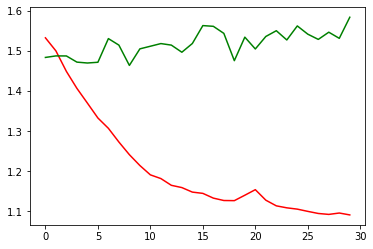

In [16]:
j = np.arange(30)
plt.plot(j, train_loss_list, 'r', j, val_loss_list, 'g')

In [17]:
def _get_accuracy(dataloader, Net):
    total = 0
    correct = 0
    Net.eval()
    for i, (images, labels) in enumerate(dataloader):
        images = Variable(images).float()
        labels = Variable(labels).float()

        outputs = Net(images, classify = True)
    
        _, label_ind = torch.max(labels, 1)
        _, pred_ind = torch.max(outputs, 1)
        
        # converting to numpy arrays
        label_ind = label_ind.data.numpy()
        pred_ind = pred_ind.data.numpy()
        
        # get difference
        diff_ind = label_ind - pred_ind
        # correctly classified will be 1 and will get added
        # incorrectly classified will be 0
        correct += np.count_nonzero(diff_ind == 0)
        total += len(diff_ind)

    accuracy = correct / total
    # print(len(diff_ind))
    return accuracy

Net = Net.cpu().eval()
# _get_accuracy(trainloader)

In [18]:
print(_get_accuracy(trainloader, Net))
print(_get_accuracy(testloader, Net))
print(_get_accuracy(valloader, Net))

0.8075
0.40625
0.328125
